# Store Item Demand Forecasting - Dataset from Kaggle

In this project we are going to forecast six week demand of different items from different stores. 

# 1. Importing Libraries

In [1]:
from IPython.core.display import HTML
from IPython.display import Image
import warnings
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import random
import warnings

# 2. Standard Functions

In [2]:
plt.style.use( 'bmh' )
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['font.size'] = 14
    
display( HTML( '<style>.container { width:100% !important; }</style>') )

warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('C:/Users/Usuario/Desktop/Data Science/Dataset Projeto/Github/Kaggle/Store Item Demand Forecasting/train.csv')

In [4]:
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


# 3. Data Description

In [5]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df['date'] = pd.to_datetime(df['date'])

# 4. Feature Engineering

In [8]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week


In [9]:
df['week_of_year'] = df['week_of_year'].astype('int64')

# 5. Descriptive statistics

In [10]:
num_attributes = df.select_dtypes(include=['int64'])

In [11]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame (num_attributes.apply( lambda x: x.kurtosis() ) ).T

#Sorting metrics 
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std' ,'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,10.0,9.0,5.500000,5.5,2.872281,0.000000,-1.224243
1,item,1.0,50.0,49.0,25.500000,25.5,14.430870,0.000000,-1.200960
2,sales,0.0,231.0,231.0,52.250287,47.0,28.801128,0.867112,0.509070
3,year,2013.0,2017.0,4.0,2015.000548,2015.0,1.414020,-0.000968,-1.299863
4,month,1.0,12.0,11.0,6.523549,7.0,3.448533,-0.009526,-1.207856
5,day,1.0,31.0,30.0,15.727820,16.0,8.799324,0.006912,-1.193855
6,week_of_year,1.0,53.0,52.0,26.615553,27.0,15.060959,0.000523,-1.199860


<AxesSubplot:xlabel='sales', ylabel='Density'>

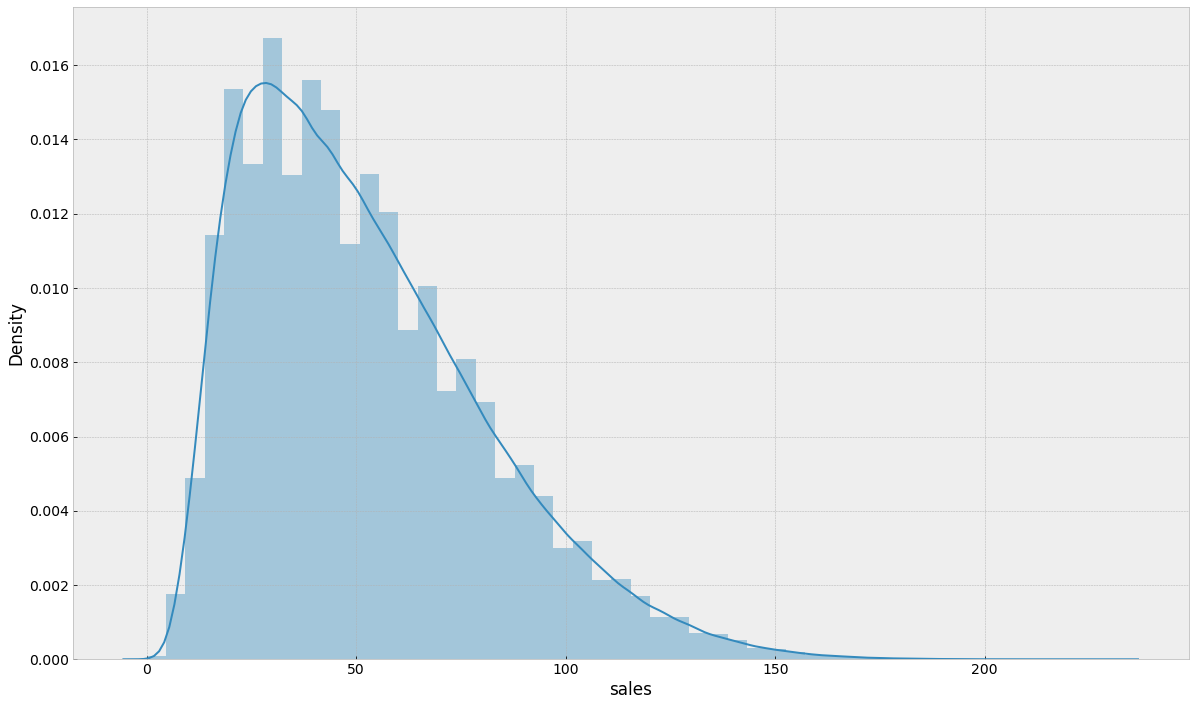

In [12]:
sns.distplot(df['sales'])

# 6. Univariate Analysis

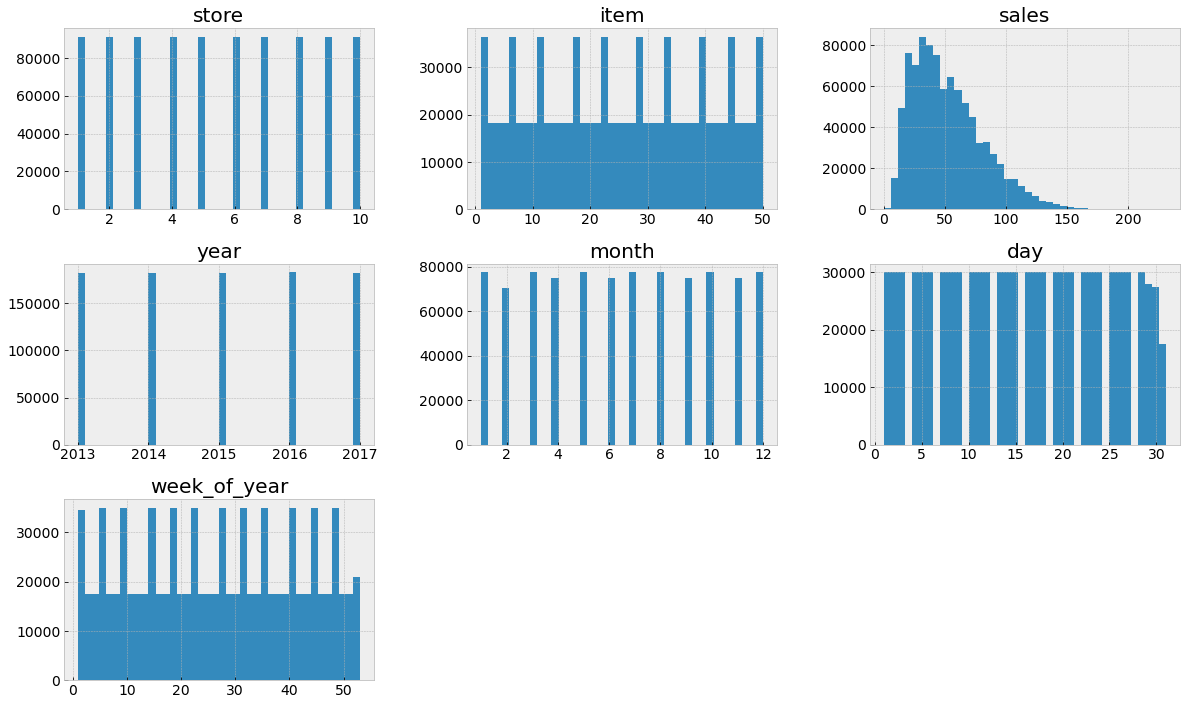

In [13]:
num_attributes.hist(bins = 40);

# 7. Multivariate Analysis

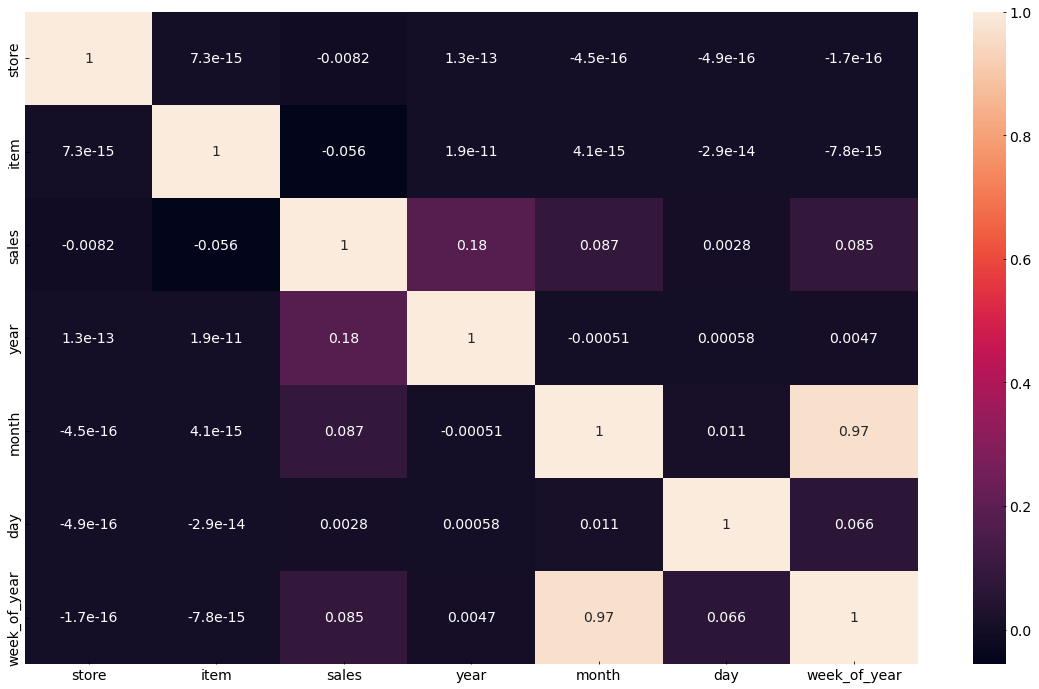

In [19]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 8. Feature Transformation

In [46]:
#Ciclic Transformation
# month
df['month_sin'] = df['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df['month_cos'] = df['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day
df['day_sin'] = df['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df['day_cos'] = df['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )

In [47]:
df

,date,store,item,sales,year,month,day,week_of_year,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,2013-01-01,1,1,2.639057,2013,1,1,1,5.000000e-01,0.866025,2.079117e-01,0.978148,1.205367e-01,0.992709
1,2013-01-02,1,1,2.484907,2013,1,2,1,5.000000e-01,0.866025,4.067366e-01,0.913545,1.205367e-01,0.992709
2,2013-01-03,1,1,2.708050,2013,1,3,1,5.000000e-01,0.866025,5.877853e-01,0.809017,1.205367e-01,0.992709
3,2013-01-04,1,1,2.639057,2013,1,4,1,5.000000e-01,0.866025,7.431448e-01,0.669131,1.205367e-01,0.992709
4,2013-01-05,1,1,2.397895,2013,1,5,1,5.000000e-01,0.866025,8.660254e-01,0.500000,1.205367e-01,0.992709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,4.158883,2017,12,27,52,-2.449294e-16,1.000000,-5.877853e-01,0.809017,-2.449294e-16,1.000000
912996,2017-12-28,10,50,4.094345,2017,12,28,52,-2.449294e-16,1.000000,-4.067366e-01,0.913545,-2.449294e-16,1.000000
912997,2017-12-29,10,50,4.317488,2017,12,29,52,-2.449294e-16,1.000000,-2.079117e-01,0.978148,-2.449294e-16,1.000000
912998,2017-12-30,10,50,4.143135,2017,12,30,52,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-2.449294e-16,1.000000


In [15]:
#Variable Response - Gaussian distribution
df['sales'] = np.log1p( df['sales'] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

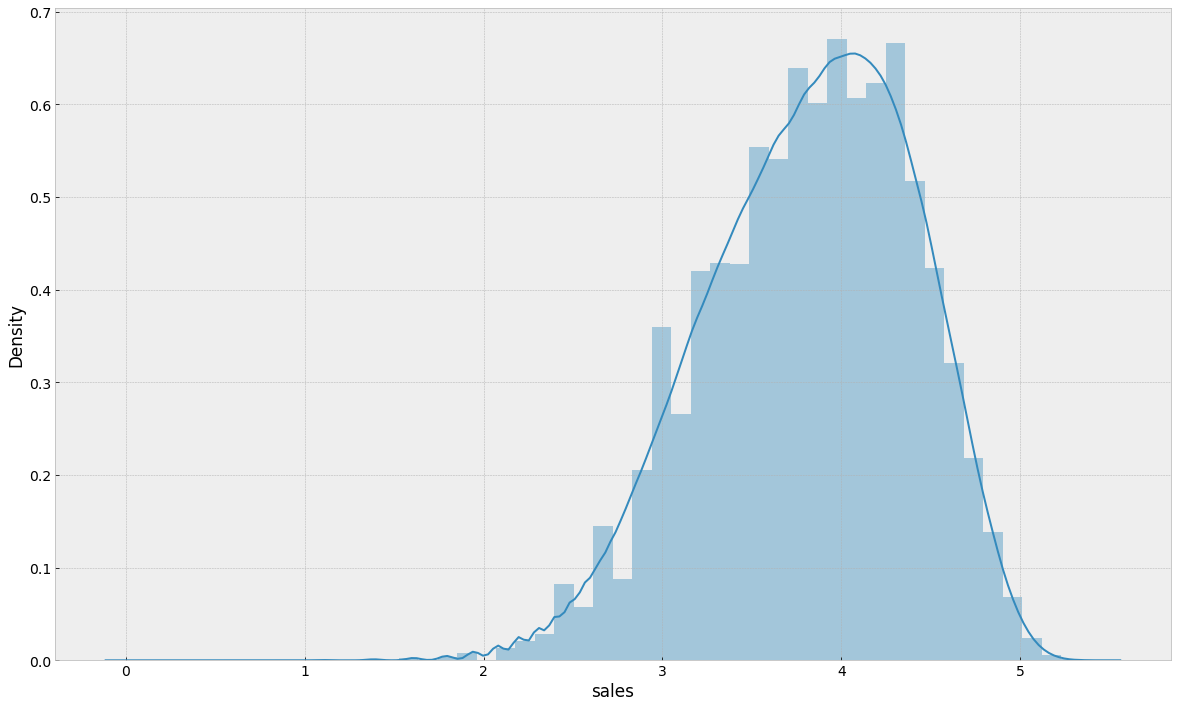

In [16]:
sns.distplot(df['sales'])

# 9. Machine Learning


In [17]:
df[['store', 'date']].groupby(['store']).max().reset_index()['date'][0] - datetime.timedelta(days= 7*6)

Timestamp('2017-11-19 00:00:00')

In [18]:
X = df[df['date'] < '2017-11-19']
y_train = X['sales']

X_train = X.drop(['date', 'sales'], axis = 1)


In [19]:
X_ = df[df['date'] >= '2017-11-19']
y_test = X_['sales']

X_test = X_.drop(['date', 'sales'], axis = 1)

In [20]:
def mean_absolute_percentage_error( y, y_pred ):
    return np.mean( np.abs( ( y - y_pred ) / y ) )

def ml_error( model_name, y, y_pred ):
    mae = mean_absolute_error( y, y_pred )
    mape = mean_absolute_percentage_error( y, y_pred )
    rmse = np.sqrt( mean_squared_error( y, y_pred ) )

    return pd.DataFrame( { 'Model Name': model_name,
                      'MAE': mae,
                      'MAPE': mape,
                      'RMSE': rmse }, index=[0] )

# 9.1. Linear Regression

In [27]:
lr = LinearRegression().fit( X_train, y_train )

# prediction
y_pred_lr = lr.predict( X_test )

# performance
lr_result = ml_error( 'Linear Regression',  np.expm1(y_test) , np.expm1(y_pred_lr) ) 
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,23.242232,0.798828,27.72043


# 9.2. Linear Regression Regularized - Lasso

In [26]:
lrr = Lasso( alpha=0.01 ).fit( X_train, y_train )

# prediction
y_pred_lrr = lrr.predict( X_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1(y_test) , np.expm1(y_pred_lrr) ) 
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,22.943568,0.782022,27.434819


# 9.3. Random Forest Regressor

In [21]:
rf = RandomForestRegressor(n_estimators = 100, n_jobs=-1, random_state=42).fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

rf_result = ml_error( 'Random Forest Regressor', np.expm1(y_test), np.expm1(y_pred_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,7.843738,0.176939,10.303707


# 9.4. XGBoost Regressor

In [28]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                                         n_estimators=100,
                                         eta=0.01,
                                         max_depth=10,
                                         subsample=0.7,
                                         colsample_bytree=0.9 ).fit( X_train, y_train )
# prediction
y_pred_xgb = model_xgb.predict( X_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1 (y_test) , np.expm1(y_pred_xgb) ) 
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,37.306141,0.70398,44.166957


# 10. Cross-Validation

In [22]:
X = df[df['date'] < '2017-11-19']

In [23]:
def cross_validation( X , kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print('\nKFold Number: {}'.format( k ) )
                  
        validation_start_date = X['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = X['date'].max() - datetime.timedelta(days = (k-1)*6*7)

        x_train_cv_inicial = X[X['date'] < validation_start_date]
        validation = X[(X['date'] >=  validation_start_date) & (X['date'] <= validation_end_date)]

        x_train_cv_final = x_train_cv_inicial.drop( ['date', 'sales'], axis=1 )
        y_train_cv_final = x_train_cv_inicial['sales']

        x_validation = validation.drop( ['date', 'sales'], axis=1 )
        y_validation = validation['sales']

        m = model.fit( x_train_cv_final, y_train_cv_final )

        y_pred_cv = m.predict( x_validation )

        m_result = ml_error( model_name, y_validation, y_pred_cv )
                  
        mae_list.append( m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                        'MAE CV': np.round( np.mean( mae_list ), 2 ).astype(str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                        'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                        'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )}, 
                                                                                                                                        index=[0] )

In [31]:
#Linear Regression Model - Cross Validation
lr_result_cv = cross_validation( X , 5, 'Linear Regression', lr ,verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,0.46 +/- 0.02,0.12 +/- 0.0,0.55 +/- 0.01


In [32]:
#Lasso - Cross Validation
lrr_result_cv = cross_validation( X, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,0.46 +/- 0.02,0.12 +/- 0.0,0.55 +/- 0.01


In [24]:
#Random Forest Regressor - Cross Validation
rf_result_cv = cross_validation( X, 5, 'Random Forest Regressor', rf ,verbose=True )
rf_result_cv



KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,0.16 +/- 0.0,0.04 +/- 0.0,0.2 +/- 0.0


In [33]:
#XGBoost Regressor - Cross Validation
xgb_result_cv = cross_validation( X , 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1.38 +/- 0.05,0.33 +/- 0.01,1.42 +/- 0.05


# 11. Comparing Model’s Performance

In [29]:
#Single Performance
modelling_result = pd.concat( [lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,7.843738,0.176939,10.303707
0,Linear Regression - Lasso,22.943568,0.782022,27.434819
0,Linear Regression,23.242232,0.798828,27.720430
0,XGBoost Regressor,37.306141,0.703980,44.166957


In [34]:
#Real Performance - Cross Validation
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv,xgb_result_cv] )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,0.46 +/- 0.02,0.12 +/- 0.0,0.55 +/- 0.01
0,Lasso,0.46 +/- 0.02,0.12 +/- 0.0,0.55 +/- 0.01
0,Random Forest Regressor,0.16 +/- 0.0,0.04 +/- 0.0,0.2 +/- 0.0
0,XGBoost Regressor,1.38 +/- 0.05,0.33 +/- 0.01,1.42 +/- 0.05


# 12. Error Translation and Interpretation

In [35]:
df2 = X_
df2['sales'] = np.expm1(df2['sales'])
df2['predictions'] = np.expm1(y_pred_rf)


In [36]:
# sum of predictions
df21 = df2[['store', 'item', 'predictions']].groupby(['store', 'item']).sum().reset_index()

# MAE and MAPE
df2_aux1 = df2[['store', 'item','sales', 'predictions']].groupby( ['store','item'] ).apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df2_aux2 = df2[['store', 'item','sales', 'predictions']].groupby( ['store','item'] ).apply(lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df2_aux3 = pd.merge( df2_aux1, df2_aux2, how='inner', on= ['store','item'])
df22 = pd.merge( df21, df2_aux3, how='inner', on=['store','item'])

# Scenarios
df22['worst_scenario'] = df22['predictions'] - df22['MAE']
df22['best_scenario'] = df22['predictions'] + df22['MAE']


# order columns
df22 = df22[['store','item', 'predictions','worst_scenario', 'best_scenario','MAE','MAPE']]

In [38]:
 df22.sort_values( 'MAPE', ascending= True).head()

,store,item,predictions,worst_scenario,best_scenario,MAE,MAPE
411,9,12,2808.600392,2802.237664,2814.963120,6.362728,0.097538
144,3,45,3561.651846,3552.438051,3570.865641,9.213795,0.102506
364,8,15,4177.796620,4167.230743,4188.362497,10.565877,0.107344
480,10,31,2544.028434,2537.634474,2550.422393,6.393960,0.108243
127,3,28,3912.139195,3901.967565,3922.310824,10.171630,0.108260


<AxesSubplot:xlabel='store', ylabel='MAPE'>

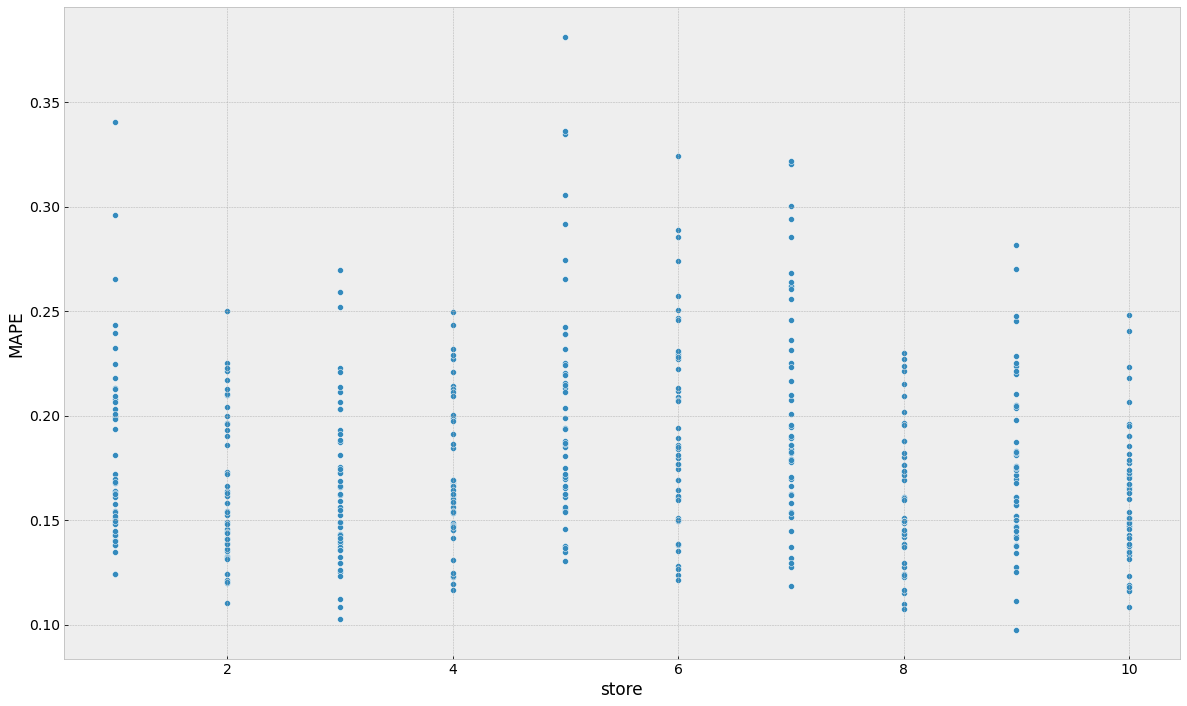

In [39]:
sns.scatterplot( x='store', y='MAPE', data=df22 )

In [42]:
#Total Perfomancce
df23 = df22[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario',
                                                                                                                                      0:'Demand'} )
df23['Demand'] = df23['Demand'].map( '{:,.2f}'.format )
df23

,Scenario,Demand
0,predictions,"997,052.47"
1,worst_scenario,"993,130.60"
2,best_scenario,"1,000,974.34"


In [43]:
df2['error'] = df2['sales'] - df2['predictions']

df2['error_rate'] = df2['predictions'] / df2['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

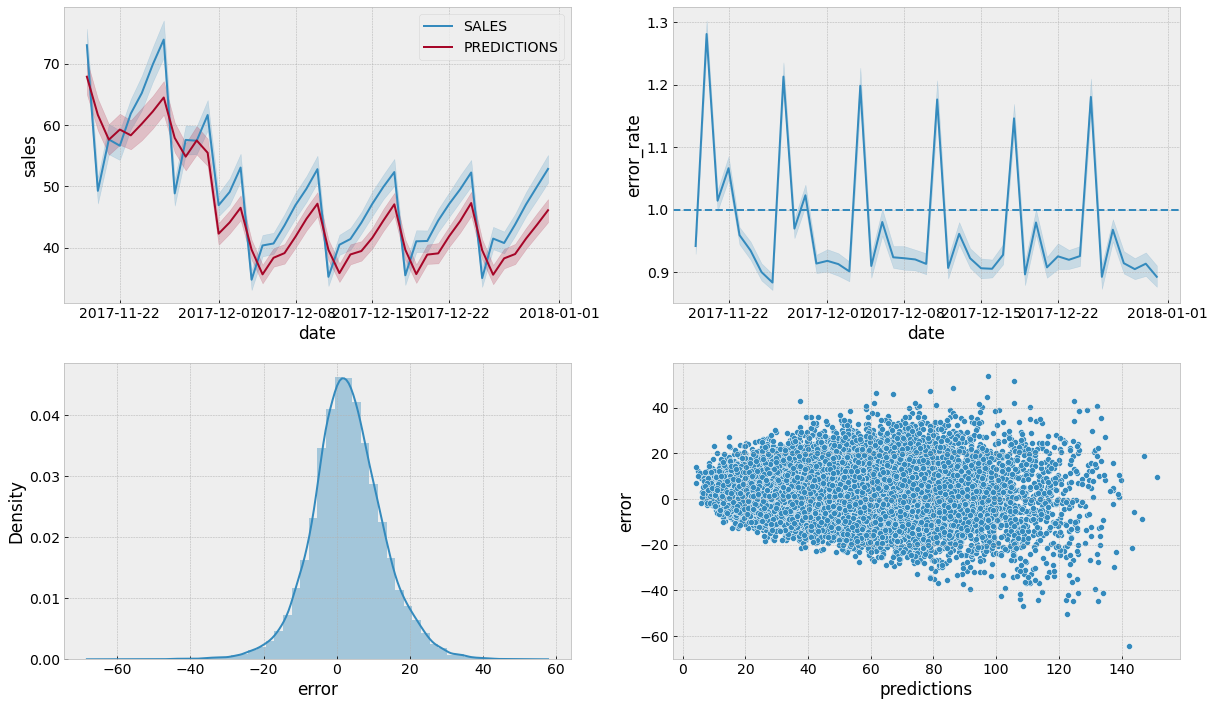

In [44]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df2, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df2, label='PREDICTIONS')

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df2 )
plt.axhline( 1, linestyle='--')
             
plt.subplot( 2, 2, 3 )
sns.distplot( df2['error'] )
             
plt.subplot( 2, 2, 4 )
sns.scatterplot( df2['predictions'], df2['error'] )